## Estimation de la loie liée au revenu moyen des ménages d'une iris

Le jeu de données provient de l’**INSEE** et décrit les **ressources économiques des ménages au niveau des IRIS** (Îlots Regroupés pour l'Information Statistique). Il s'agit d'unités statistiques infra-communales. Le jeu de données est composé de **13 674 entrées**. 

lien du dataset: https://www.insee.fr/fr/statistiques/8229323 

On s’intéresse à la variable `DEC_MED21`, qui correspond au **revenu médian annuel** des ménages au sein d'un IRIS.

On notera :
$$X = \text{DEC\_MED21}, \qquad X > 0$$

Par la suite on tentera de modéliser la distribution de `DEC_MED21`, on supposera que $X$ suit une **loi log-normale** :
$$X \sim \text{Log-normale}(m, \sigma^2) \quad \Longleftrightarrow \quad \log(X) \sim \mathcal{N}(m, \sigma^2)$$

Les paramètres $m$  et $\sigma^2$ de cette loi seront estimés à partir de notre échantillon dans la suite de cette étude.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy import stats

## Chargement des données et Dataprep

In [2]:
path = "dataset/BASE_TD_FILO_IRIS_2021_DEC.csv"


df = pd.read_csv(path, sep=";", decimal=",")
num_cols = [col for col in df.columns if df[col].str.contains(",", na=False).any()]

for col in num_cols:
    df[col] = df[col].str.replace(",", ".", regex=False)
    df[col] = pd.to_numeric(df[col], errors="coerce")

col_NaN = [c for c in df.columns if df[c].isnull().mean()*100 > 60.0]
print("nb colonnes avec  60% de NaN",len(col_NaN))

quasi_constant = df.columns[
    df.apply(
        lambda x : x.value_counts(normalize=True).iloc[0]
        if x.dropna().size > 0 else 0
    ) > 0.90
]
print("\n nb de colonnes avec 90 % des données avec la même valeur :", len(quasi_constant))

nb colonnes avec  60% de NaN 0

 nb de colonnes avec 90 % des données avec la même valeur : 0


In [3]:
def audit(df):
    return pd.DataFrame({
        "dtype": df.dtypes,
        "missing": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique": df.nunique(),
        "sample": df.iloc[0]
    })


audit(df)

,dtype,missing,missing_%,unique,sample
IRIS,object,0,0.00,16026,010040101
DEC_PIMP21,float64,1536,9.58,83,43.0
DEC_TP6021,float64,1537,9.59,85,29.0
DEC_INCERT21,object,0,0.00,3,2
DEC_Q121,object,0,0.00,2737,12610
DEC_MED21,object,0,0.00,3498,19330
DEC_Q321,object,0,0.00,4343,26390
DEC_EQ21,float64,1536,9.58,190,0.71
DEC_D121,object,0,0.00,1953,7760
DEC_D221,object,0,0.00,2573,11300


In [4]:
df = df.dropna()
na_counts = df.isna().sum().sort_values(ascending=False)
na_counts

IRIS            0
DEC_PIMP21      0
DEC_TP6021      0
DEC_INCERT21    0
DEC_Q121        0
DEC_MED21       0
DEC_Q321        0
DEC_EQ21        0
DEC_D121        0
DEC_D221        0
DEC_D321        0
DEC_D421        0
DEC_D621        0
DEC_D721        0
DEC_D821        0
DEC_D921        0
DEC_RD21        0
DEC_S80S2021    0
DEC_GI21        0
DEC_PACT21      0
DEC_PTSA21      0
DEC_PCHO21      0
DEC_PBEN21      0
DEC_PPEN21      0
DEC_PAUT21      0
DEC_NOTE21      0
dtype: int64

In [5]:
df.shape

(13674, 26)

In [6]:
df.describe()

,DEC_PIMP21,DEC_TP6021,DEC_EQ21,DEC_RD21,DEC_S80S2021,DEC_GI21,DEC_PACT21,DEC_PTSA21,DEC_PCHO21,DEC_PBEN21,DEC_PPEN21,DEC_PAUT21
count,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000
mean,53.881600,24.743235,0.819758,18.694669,9.932280,0.362767,68.288409,60.762608,3.254073,4.271727,26.124448,5.587143
std,14.230925,13.594410,0.191954,148.426722,6.484679,0.063986,9.691292,9.789245,1.256660,2.418706,8.940358,5.200029
min,7.000000,3.000000,0.410000,2.400000,2.800000,0.198000,19.400000,16.500000,0.400000,0.200000,-0.300000,0.000000
25%,43.000000,14.000000,0.670000,4.500000,5.900000,0.319000,62.300000,54.600000,2.400000,2.500000,19.600000,2.700000
50%,54.000000,22.000000,0.790000,6.200000,8.100000,0.358000,68.800000,61.400000,3.000000,3.800000,25.500000,4.300000
75%,65.000000,33.000000,0.940000,9.200000,11.500000,0.399000,75.100000,67.800000,3.900000,5.500000,31.900000,6.600000
max,91.000000,83.000000,1.870000,6617.000000,150.300000,0.803000,98.200000,96.500000,13.300000,31.700000,66.400000,69.500000


In [7]:
vars_of_interest = [
    "DEC_MED21",    # Revenu médian
]

subset = df[vars_of_interest].copy()
subset.head()


,DEC_MED21
0,19330
1,16830
2,19940
3,25560
4,19870


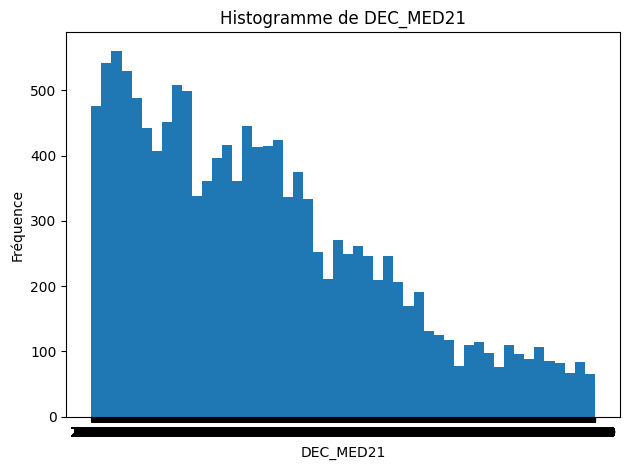

In [8]:
for col in vars_of_interest:
    data = subset[col]
    plt.figure()
    plt.hist(data, bins = 50)
    plt.title(f"Histogramme de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()

On observe que la variable  `DEC_MED21`, le Revenu médian semble suivre une  **loi log-normale**

Nous proposons donc de construire deux estimateurs distincts afin d’estimer cette loie:
1. les estimateurs des maximum de vraissemblance
2. les etimateurs des moments


Vérifions que `DEC_MED21` suis bien une loie log normal pour se faire nous allons dans un premier temps vérifier la distibution de `log(DEC_MED21)` et enfin l'adéquation à une loi normale 

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


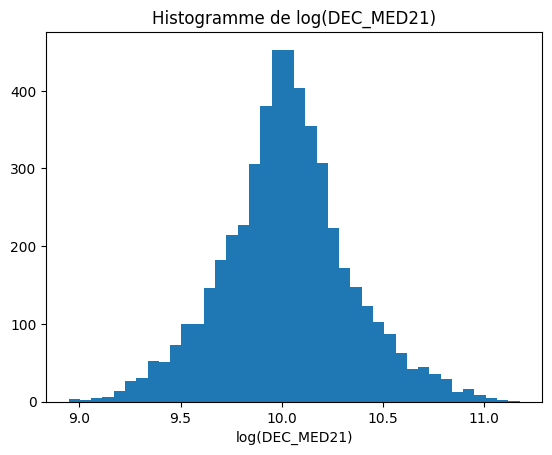

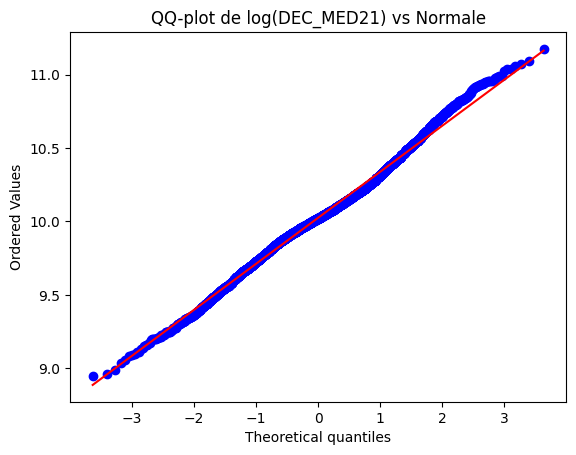

In [9]:
sub = df["DEC_MED21"].dropna().astype(np.number).to_frame()
sub["IRIS"] = df.loc[sub.index, "IRIS"]
sub["DEC_MED21"] = pd.to_numeric(sub["DEC_MED21"], errors="coerce")
sub = sub[sub["DEC_MED21"] > 0]   


sub_sample = sub.sample(n=5000, random_state=42)


x = sub_sample["DEC_MED21"].to_numpy()
logx = np.log(x)

# Histogramme
plt.figure()
plt.hist(logx, bins=40)
plt.title("Histogramme de log(DEC_MED21)")
plt.xlabel("log(DEC_MED21)")
plt.show()

# QQ-plot
plt.figure()
stats.probplot(logx, dist="norm", plot=plt)
plt.title("QQ-plot de log(DEC_MED21) vs Normale")
plt.show()

On a bien log(DEC_MED21) qui suis une loie normale, comme le montrent sa densité et le graphique QQ-plot. On va donc estimer ses paramètres en supposant une loi normale dans un premier temps. 

## Estimation des paramètres d’une loi log-normale

### Estimation par le maximum de vraisemblance

Notre supposition que la variable aléatoire $X$ suit une loi log-normale est donc justifié par le QQ-plot et sa densité.

On a donc :
$$
E[X] = e^{m + \frac{\sigma^2}{2}} \qquad \text{et} \qquad V[X] = (e^{\sigma^2} - 1)e^{2m + \sigma^2}
$$

 
Par définition, cela signifie que la variable transformée

$$
Y = \log(X)
$$


suit une loi normale de paramètres $m$ et $\sigma^2$, notée :

$$
Y \sim \mathcal{N}(m,\sigma^2)
$$

Soit $(x_1,\ldots,x_n)$ un échantillon i.i.d. issu de la loi de $X$,
avec $x_i > 0$ pour tout $i$.
On définit alors

$$
y_i = \log(x_i),
$$

de sorte que $(y_1,\ldots,y_n)$ est un échantillon i.i.d. issu de
$\mathcal{N}(m,\sigma^2)$.

---

### Fonction de vraisemblance

La densité d’une variable normale $\mathcal{N}(m,\sigma^2)$ est donnée par :

$$
f(y)
=
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\left(
-\frac{(y-m)^2}{2\sigma^2}
\right)
$$

La fonction de vraisemblance associée à l’échantillon
$(y_1,\ldots,y_n)$ s’écrit donc :

$$
L(m,\sigma^2)
=
\prod_{i=1}^{n}
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\left(
-\frac{(y_i-m)^2}{2\sigma^2}
\right)
$$

---

### Log-vraisemblance

On va chercher les maximums de vraissemblance pour se faire on considère la log-vraisemblance :

$$
\ell(m,\sigma^2)
=
\log L(m,\sigma^2)
$$

ce qui donne :

$$
\ell(m,\sigma^2)
=
-\frac{n}{2}\log(2\pi)
-\frac{n}{2}\log(\sigma^2)
-\frac{1}{2\sigma^2}
\sum_{i=1}^{n}(y_i-m)^2
$$

---

### Calcul des estimateurs du maximum de vraisemblance

On dérive la log-vraisemblance par rapport à $m$ :

$$
\frac{\partial \ell}{\partial m}
=
\frac{1}{\sigma^2}
\sum_{i=1}^{n}(y_i-m)
$$

En annulant cette dérivée, on obtient la condition du premier ordre :

$$
\sum_{i=1}^{n}(y_i-m) = 0
\quad \Longrightarrow \quad
\hat{m}
=
\frac{1}{n}
\sum_{i=1}^{n} y_i
$$

On dérive ensuite la log-vraisemblance par rapport à $\sigma^2$ :

$$
\frac{\partial \ell}{\partial \sigma^2}
=
-\frac{n}{2\sigma^2}
+
\frac{1}{2\sigma^4}
\sum_{i=1}^{n}(y_i-m)^2
$$

L’annulation de cette dérivée conduit à l’estimateur :

$$
\hat{\sigma}^2
=
\frac{1}{n}
\sum_{i=1}^{n}(y_i-\hat{m})^2
$$

Afin de vérifier que ces estimateurs correspondent bien à un maximum
de la fonction de log-vraisemblance, on étudie les dérivées secondes.

La dérivée seconde par rapport à $m$ est donnée par :

$$
\frac{\partial^2 \ell}{\partial m^2}
=
-\frac{n}{\sigma^2}
< 0
$$

ce qui montre que la fonction atteint un maximum en  $m$.

De même, la dérivée seconde par rapport à $\sigma^2$ est :

$$
\frac{\partial^2 \ell}{\partial (\sigma^2)^2}
=
-\frac{n}{2(\sigma^2)^2}
< 0
$$

Ainsi, les points critiques obtenus correspondent bien à des maxima
de la log-vraisemblance.


---

Une variable X suit une loi log-normale de paramètres (m,σ2) si et seulement si log(X) suit une loi normale de paramètres (m,σ2).
 - L'EMV de m pour la loi normale de log(X) est l'EMV de m pour la loi log-normale de X.  
 -  L'EMV de σ2 pour la loi normale de log(X) est l'EMV de σ2 pour la loi log-normale de X.

In [10]:
# moyenne empirique
moy_emp = np.mean(x)
#variance empirque 
var_emp = np.var(x, ddof=1)

print("Moyenne empirique  =", moy_emp)
print("Variance empirique non biaisée (ddof=1) =", var_emp)

Moyenne empirique  = 23751.998
Variance empirique non biaisée (ddof=1) = 62033760.58011202


In [11]:
n = len(logx)

# moyenne
m_hat_emv = (1/n) * np.sum(logx)

# variance 
sigma2_hat_emv = (1/(n-1)) * np.sum((logx - m_hat_emv)**2)

# écart-type
sigma_hat_emv = np.sqrt(sigma2_hat_emv)

print("Estimateur Maximun de vraissemblance de m :", m_hat_emv)
print("Estimateur max de vraissemblance de la variance :", sigma2_hat_emv)

Estimateur Maximun de vraissemblance de m : 10.025380193806052
Estimateur max de vraissemblance de la variance : 0.09862218315695598


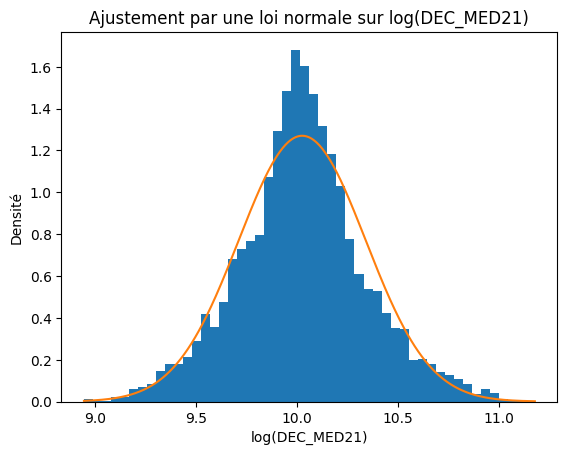

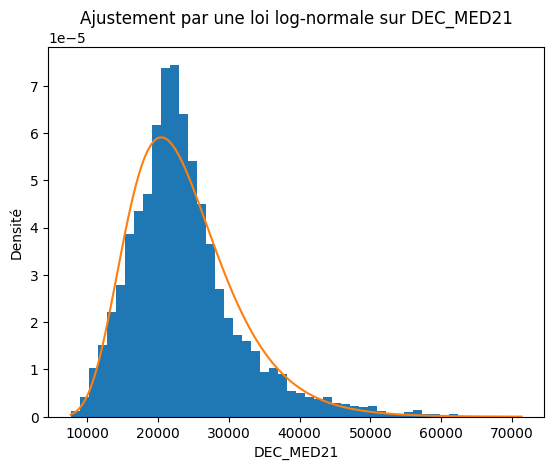

In [12]:
from scipy.stats import norm, lognorm
# grille pour log(X)
x_log = np.linspace(logx.min(), logx.max(), 500)

# densité normale estimée
pdf_normal = norm.pdf(x_log, loc=m_hat_emv, scale=sigma_hat_emv)

plt.figure()
plt.hist(logx, bins=50, density=True)
plt.plot(x_log, pdf_normal)
plt.title("Ajustement par une loi normale sur log(DEC_MED21)")
plt.xlabel("log(DEC_MED21)")
plt.ylabel("Densité")
plt.show()

# grille pour X
x_grid = np.linspace(x.min(), x.max(), 500)

# densité log-normale estimée
pdf_lognorm = lognorm.pdf(x_grid, s=sigma_hat_emv, scale=np.exp(m_hat_emv))

plt.figure()
plt.hist(x, bins=50, density=True)
plt.plot(x_grid, pdf_lognorm)
plt.title("Ajustement par une loi log-normale sur DEC_MED21")
plt.xlabel("DEC_MED21")
plt.ylabel("Densité")
plt.show()


Ces deux grpahes confirment que le revenu médian (DEC_MED21) suit bien une loi log-normale et que nos estimateurs semblent correspondrent à la loie que suit les données. 

#### Estimations par la méthode des moments 


On a $X \sim \text{Log-Normal}(m, \sigma^2)$, comme dit avant: 

$$
E[X] = e^{m + \frac{\sigma^2}{2}} \qquad \text{et} \qquad V[X] = (e^{\sigma^2} - 1)e^{2m + \sigma^2}
$$

Soit $(x_1, \dots, x_n)$ un échantillon i.i.d. issu de la loi de $X$. On définit la moyenne empirique $\bar{x}$ et la variance empirique $s^2$ par :

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i \quad \text{et} \quad s^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2
$$

---

### Système d'équations des moments

L'estimation des paramètres consiste à résoudre le système d'équations suivant:

$$
\begin{cases} 
e^{m + \frac{\sigma^2}{2}} = \bar{x} & (1) \\
(e^{\sigma^2} - 1)e^{2m + \sigma^2} = s^2 & (2)
\end{cases}
$$

---

### Calcul de l'estimateur de $\sigma^2$

On remarque que le terme $e^{2m + \sigma^2}$ dans l'équation (2) peut s'écrire comme le carré de l'expression de l'espérance issue de l'équation (1) :

$$
(e^{m + \frac{\sigma^2}{2}})^2 = e^{2m + \sigma^2} = \bar{x}^2
$$

En substituant cette égalité dans l'équation (2), on obtient :

$$
(e^{\sigma^2} - 1) \bar{x}^2 = s^2
$$

$$
e^{\sigma^2} - 1 = \frac{s^2}{\bar{x}^2} \quad \Longrightarrow \quad e^{\sigma^2} = 1 + \frac{s^2}{\bar{x}^2}
$$

Donc:

$$
\hat{\sigma}^2_{MM} = \log\left(1 + \frac{s^2}{\bar{x}^2}\right)
$$

---

### Calcul de l'estimateur de $m$

D'après (1) :

$$
m + \frac{\sigma^2}{2} = \log(\bar{x})
$$

En utilisant l'estimateur $\hat{\sigma}^2_{MM}$ précédemment calculé, on trouve :

$$
\hat{m}_{MM} = \log(\bar{x}) - \frac{1}{2} \hat{\sigma}^2_{MM}
$$

L'estimateur final est :

$$
\hat{m}_{MM} = \log(\bar{x}) - \frac{1}{2} \log\left(1 + \frac{s^2}{\bar{x}^2}\right)
$$
Pour le reste des calculs on utilisera cette formule : 
$$
\hat{m}_{MM} = \log(\bar{x}) - \frac{1}{2} \hat{\sigma}^2_{MM}
$$

---

In [13]:
# Formules correctes
sigma2_hat_mm = np.log(1 + (var_emp / moy_emp**2))
m_hat_mm = np.log(moy_emp) - 0.5 * sigma2_hat_mm

# Calcul de l'écart-type
sigma_hat_mm = np.sqrt(sigma2_hat_mm)

print("Estimateur des moments de m :", m_hat_mm)
print("Estimateur des moments de  la variance:", sigma2_hat_mm) 

Estimateur des moments de m : 10.0232607319065
Estimateur des moments de  la variance: 0.10432240066731328


Les estimateurs sont proches des résultats obtenu précedements nous allons maintenant vérifier les propriétés des estimateurs 

#### Vérifions les propriétés des estimateurs 

Nous allons vérifier les propriétés des estimateurs du Maximum de Vraisemblance ($\hat{m}_{EMV}, \hat{\sigma}^2_{EMV}$) et de la Méthode des Moments ($\hat{m}_{MM}, \hat{\sigma}^2_{MM}$).

---

### 1. Vérifions les biais des estimateurs 

Un estimateur $\hat{\theta}$ est dit sans biais si $E[\hat{\theta}] = \theta$.

* **Pour l'EMV :**
    * L'estimateur $\hat{m}$ est **sans biais** :
        $$\hat{m}_{EMV} = \frac{1}{n}\sum_{i=1}^{n} y_i \implies E[\hat{m}_{EMV}] = \frac{1}{n}\sum_{i=1}^{n} E[y_i] = \frac{1}{n}(n \cdot m) = m$$
        alors 
        $$E[\hat{m}_{EMV}] = m$$

    * L'estimateur $\hat{\sigma}^2$ est **biaisé** pour un échantillon fini : (démonstation en Annexe)
        $$E[\hat{\sigma}^2_{EMV}] = \frac{n-1}{n}\sigma^2$$

        mais il est asymptotiquement sans biais 
        $$\lim_{n \to \infty} \frac{n-1}{n} \sigma^2 = \sigma^2$$

    
* **Pour les Moments (MM) :**
    Nous avons obtenu les estimateurs suivants : 
    $$\hat{\sigma}^2_{MM} = \log\left(1 + \frac{s^2}{\bar{x}^2}\right) \qquad \text{et} \qquad \hat{m}_{MM} = \log(\bar{x}) - \frac{1}{2}\hat{\sigma}^2_{MM}$$


    Ces estimateurs sont **biaisés** car   les fonctions  logarithme et quotient ne sont pas linéaires. 
    (La démonstration est en annexes) Nous mettrons en avant ici les méthodes utilisées et les résultats obtenus :

    1. **L'Inégalité de Jensen** : Pour une fonction strictement concave comme le logarithme, on a $E[\log(Z)] < \log(E[Z])$.
    
    2. **Application à $\hat{m}_{MM}$** : Le premier terme de l'estimateur est $\log(\bar{x})$. Comme la fonction $\log$ est concave, l'espérance de la fonction est inférieure à la fonction de l'espérance : $E[\log(\bar{x})] \neq \log(E[\bar{x}])$. 
    3. **Conséquence** :  $E[\hat{m}_{MM}] \neq m$ et $E[\hat{\sigma}^2_{MM}] \neq \sigma^2$. 

    Cependant, ils sont **asymptotiquement sans biais** car, par continuité des fonctions et application de la Loi Forte des Grands Nombres ($\bar{x} \xrightarrow{p.s.} E[X]$ et $s^2 \xrightarrow{p.s.} V[X]$) :
    $$\lim_{n \to \infty} E[\hat{m}_{MM}] = m \qquad \text{et} \qquad \lim_{n \to \infty} E[\hat{\sigma}^2_{MM}] = \sigma^2$$

---

### 2. Loi Forte des Grands Nombres

La **Loi Forte des Grands Nombres** garantit que la moyenne empirique converge presque sûrement vers l'espérance théorique lorsque $n \to \infty$, à condition que la variable $X$ admette un moment d'ordre 1 fini ($E[|X|] < \infty$).

C'est bien le cas pour notre étude  nous vérifierons par la suite son application. On a donc nos estimateurs qui convergent vers les paramètres :

$$
\hat{\theta}_n \xrightarrow{p.s.} \theta
$$

---

### 3. Théorème de la Limite Centrale 

Le **Théorème de la Limite Centrale** indique que pour un échantillon de grande taille ($n \to \infty$), si $X$ admet un moment d'ordre 2 fini on a alors: 

$$
\sqrt{n}(\hat{\theta}_n - \theta) \xrightarrow{\mathcal{L}} \mathcal{N}(0, \sigma^2)
$$
Où $m = E[X]$ et $\sigma^2 = V[X]$.

C'est bien le cas pour notre étude  nous vérifierons par la suite son application.


---

--- Vérification du Biais (n=30) ---
m_ref : 10.026414 | E[m_EMV] : 10.027541 | E[m_MM] : 10.025993
sigma2_ref : 0.097093 | E[sigma2_EMV] : 0.096408 | E[sigma2_MM] : 0.097667


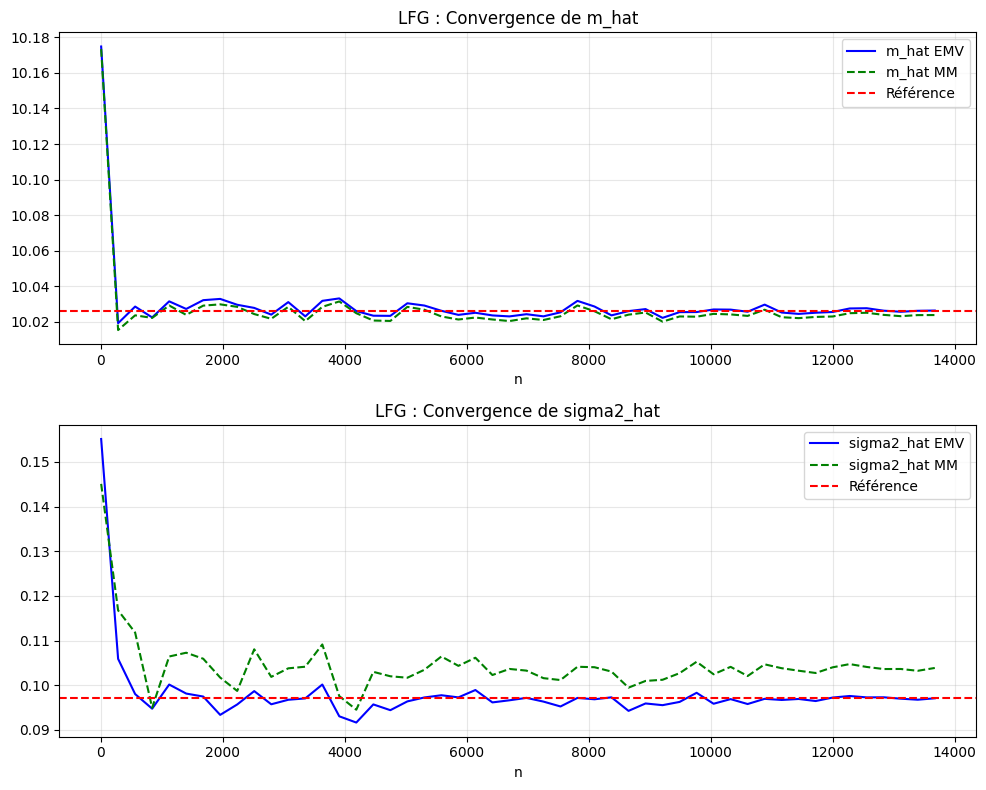

In [17]:
def get_mle_estimates(x):
    log_x = np.log(x)
    m_hat = np.mean(log_x)
    sigma2_hat = np.var(log_x, ddof=1)
    return m_hat, sigma2_hat

def get_mm_estimates(x):
    x_bar = np.mean(x)
    v_emp = np.var(x)
    sigma2_hat = np.log(1 + v_emp / x_bar**2)
    m_hat = np.log(x_bar) - 0.5 * sigma2_hat
    return m_hat, sigma2_hat

x_pop = sub["DEC_MED21"].to_numpy()
logx_pop = np.log(x_pop)
m_ref = np.mean(logx_pop)
sigma2_ref = np.var(logx_pop, ddof=1)
sigma_ref = np.sqrt(sigma2_ref)
n_pop = len(x_pop)

n_small = 30
n_trials = 5000
results = {key: [] for key in ["mle_m", "mle_s2", "mm_m", "mm_s2"]}

for _ in range(n_trials):
    sample = np.random.choice(x_pop, n_small, replace=True)
    for name, func in [("mle", get_mle_estimates), ("mm", get_mm_estimates)]:
        m, s2 = func(sample)
        results[f"{name}_m"].append(m)
        results[f"{name}_s2"].append(s2)

print(f"--- Vérification du Biais (n={n_small}) ---")
print(f"m_ref : {m_ref:.6f} | E[m_EMV] : {np.mean(results['mle_m']):.6f} | E[m_MM] : {np.mean(results['mm_m']):.6f}")
print(f"sigma2_ref : {sigma2_ref:.6f} | E[sigma2_EMV] : {np.mean(results['mle_s2']):.6f} | E[sigma2_MM] : {np.mean(results['mm_s2']):.6f}")

n_values = np.linspace(10, n_pop, 50, dtype=int)
conv = {key: [] for key in ["mle_m", "mle_s2", "mm_m", "mm_s2"]}

for n in n_values:
    sample = np.random.choice(x_pop, n, replace=False)
    m_mle, s2_mle = get_mle_estimates(sample)
    m_mm, s2_mm = get_mm_estimates(sample)
    conv["mle_m"].append(m_mle)
    conv["mle_s2"].append(s2_mle)
    conv["mm_m"].append(m_mm)
    conv["mm_s2"].append(s2_mm)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(n_values, conv["mle_m"], label='m_hat EMV', color='blue')
axes[0].plot(n_values, conv["mm_m"], label='m_hat MM', color='green', linestyle='--')
axes[0].axhline(m_ref, color='red', linestyle='--', label='Référence')
axes[0].set_title('LFG : Convergence de m_hat')
axes[0].set_xlabel('n')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(n_values, conv["mle_s2"], label='sigma2_hat EMV', color='blue')
axes[1].plot(n_values, conv["mm_s2"], label='sigma2_hat MM', color='green', linestyle='--')
axes[1].axhline(sigma2_ref, color='red', linestyle='--', label='Référence')
axes[1].set_title('LFG : Convergence de sigma2_hat')
axes[1].set_xlabel('n')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

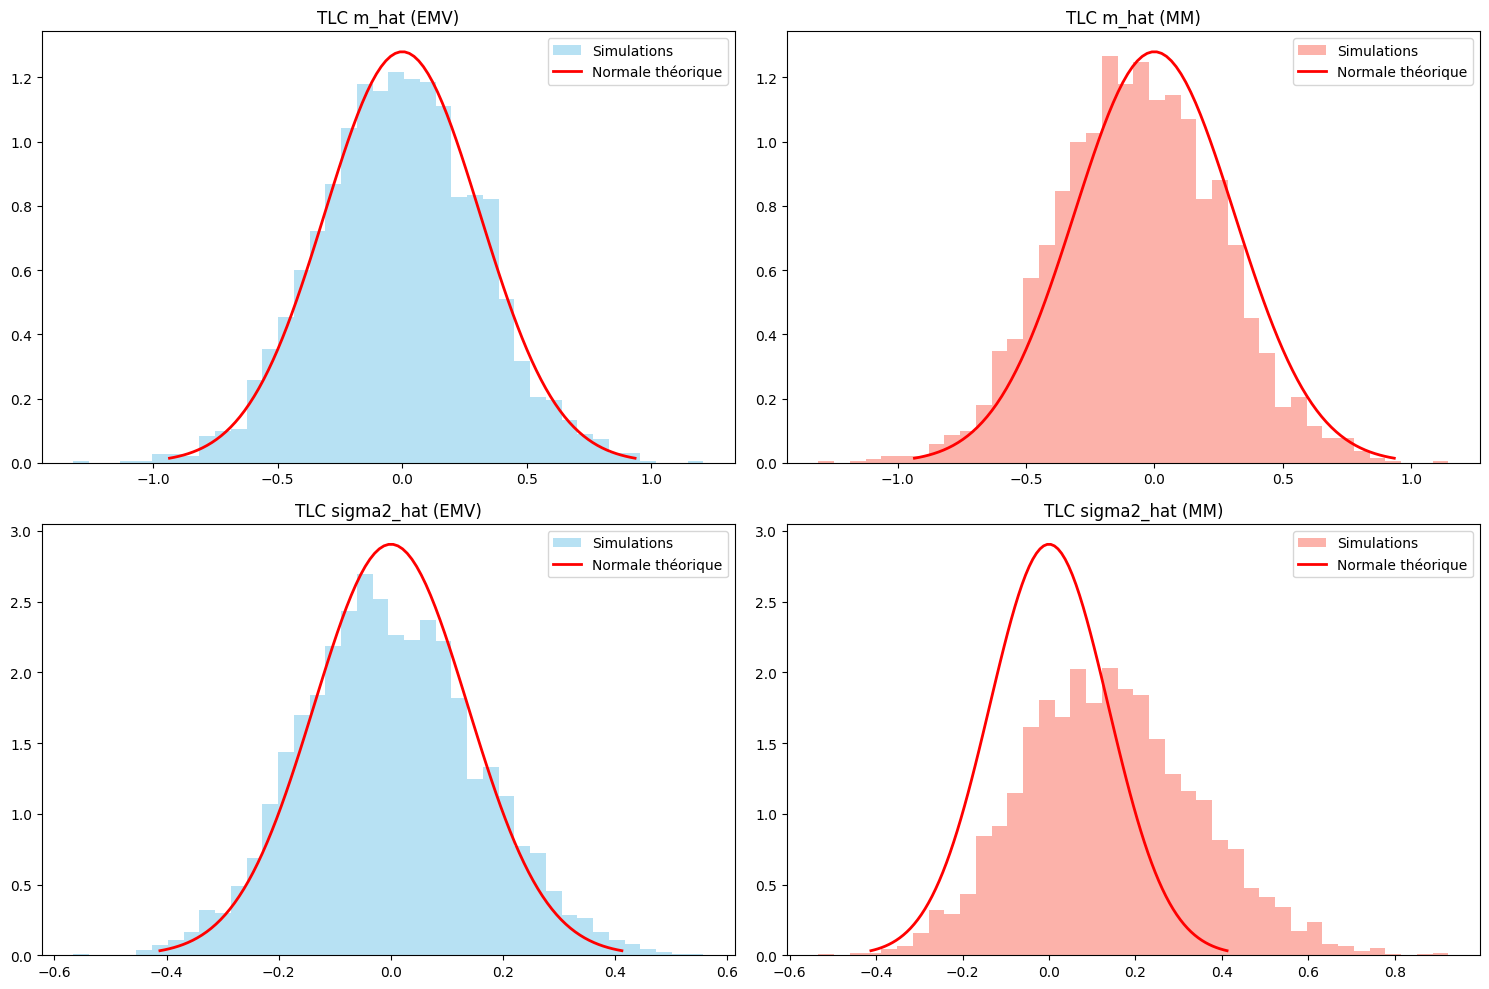

In [18]:
n_clt = 500
n_clt_values = [30, 100, 500, 2000]
n_rep = 3000

err = {key: [] for key in ["mle_m", "mm_m", "mle_s2", "mm_s2"]}

for _ in range(3000):
    sample = np.random.choice(x_pop, n_clt, replace=True)
    m_mle, s2_mle = get_mle_estimates(sample)
    m_mm, s2_mm = get_mm_estimates(sample)
    err["mle_m"].append(np.sqrt(n_clt)*(m_mle - m_ref))
    err["mm_m"].append(np.sqrt(n_clt)*(m_mm - m_ref))
    err["mle_s2"].append(np.sqrt(n_clt)*(s2_mle - sigma2_ref))
    err["mm_s2"].append(np.sqrt(n_clt)*(s2_mm - sigma2_ref))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
x_m = np.linspace(-3*sigma_ref, 3*sigma_ref, 100)
pdf_m = stats.norm.pdf(x_m, 0, sigma_ref)
axes[0, 0].hist(err["mle_m"], bins=40, density=True, alpha=0.6, color='skyblue', label='Simulations')
axes[0, 0].plot(x_m, pdf_m, color='red', lw=2, label='Normale théorique')
axes[0, 0].set_title('TLC m_hat (EMV)')
axes[0, 0].legend()

axes[0, 1].hist(err["mm_m"], bins=40, density=True, alpha=0.6, color='salmon', label='Simulations')
axes[0, 1].plot(x_m, pdf_m, color='red', lw=2, label='Normale théorique')
axes[0, 1].set_title('TLC m_hat (MM)')
axes[0, 1].legend()

std_err_s2 = np.sqrt(2 * sigma2_ref**2)
x_s2 = np.linspace(-3*std_err_s2, 3*std_err_s2, 100)
pdf_s2 = stats.norm.pdf(x_s2, 0, std_err_s2)
axes[1, 0].hist(err["mle_s2"], bins=40, density=True, alpha=0.6, color='skyblue', label='Simulations')
axes[1, 0].plot(x_s2, pdf_s2, color='red', lw=2, label='Normale théorique')
axes[1, 0].set_title('TLC sigma2_hat (EMV)')
axes[1, 0].legend()

axes[1, 1].hist(err["mm_s2"], bins=40, density=True, alpha=0.6, color='salmon', label='Simulations')
axes[1, 1].plot(x_s2, pdf_s2, color='red', lw=2, label='Normale théorique')
axes[1, 1].set_title('TLC sigma2_hat (MM)')
axes[1, 1].legend()
plt.tight_layout()
plt.show()


#### Interprétation

L'EMV est plus performant que la méthode des moments car il est sans biais (pour m), et a variance minimale, et converge plus vite vers la réalité. Les tests confirment que nos estimateurs sont consistants et suivent une loi normale.

### 4. Efficacité et Information de Fisher

Un estimateur est considéré comme **optimal** s'il atteint la **Borne de Cramér-Rao (BCR)**. La borne est donnée par l'inverse de l'Information de Fisher pour un échantillon de taille $n$ :
$$Var(\hat{\theta}) \geq \text{BCR}(\theta) = \frac{1}{n \cdot I(\theta)}$$

Pour la loi log-normale, la matrice d'Information de Fisher est :
$$I(m, \sigma^2) = \begin{pmatrix} \frac{1}{\sigma^2} & 0 \\ 0 & \frac{1}{2\sigma^4} \end{pmatrix}$$

---


Puisque $X \sim \text{Lognormale}(m, \sigma^2)$, alors $Y = \log(X) \sim \mathcal{N}(m, \sigma^2)$. L'EMV estime les paramètres d'une loi normale sur les données transformées $y_i = \log(x_i)$.

**A. Variance de $\hat{m}_{EMV}$ :**
$\hat{m}_{EMV}$ est la moyenne empirique des $y_i$ : $\hat{m} = \bar{y} = \frac{1}{n} \sum y_i$.
$$Var(\hat{m}_{EMV}) = Var\left( \frac{1}{n} \sum_{i=1}^n y_i \right) = \frac{1}{n^2} \sum_{i=1}^n Var(y_i) = \frac{n\sigma^2}{n^2} = \frac{\sigma^2}{n}$$
On a $Var(\hat{m}_{EMV}) = \text{BCR}(m)$, l'estimateur est donc **efficace**.

**B. Variance de $\hat{\sigma}^2_{EMV}$ :**
Pour la variance de  $\hat{\sigma}^2_{EMV}$ nous obtenons: 
$$Var(\hat{\sigma}^2_{EMV}) = \frac{2\sigma^4}{n-1}$$
Asymptotiquement ($n \to \infty$), on atteint la borne $\frac{2\sigma^4}{n} = \text{BCR}(\sigma^2)$.

---

Les estimateurs MM sont des fonctions non-linéaires des moments empiriques de $X$. 


**A. Variance de $\hat{m}_{MM}$ :**
Par la méthode Delta, on montre que :
$$Var(\hat{m}_{MM}) \approx \frac{\sigma^2}{n} + \frac{\sigma^4}{2n}$$
On observe que $Var(\hat{m}_{MM}) > \text{BCR}(m)$.

Il n'est pas nécessaire de calculer la variance pour $\hat{\sigma}^2_{MM}$

---

**Conclusion :** L'EMV est la méthode d'estimation à privilégier car il est **asymptotiquement efficace** 

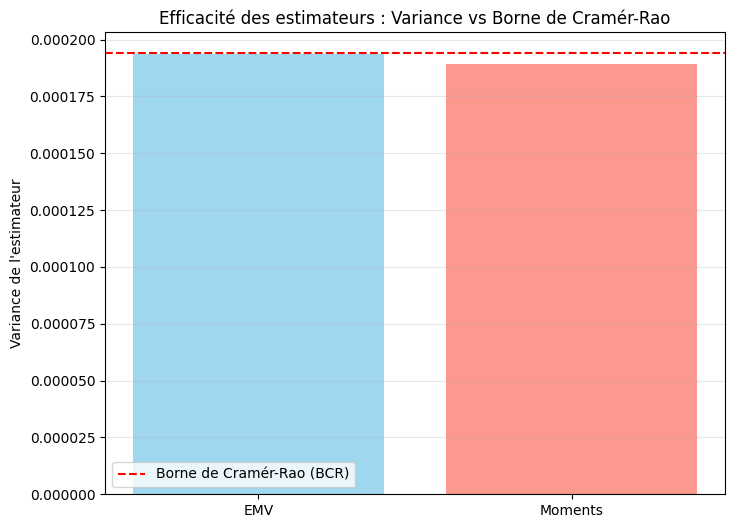

In [19]:
# --- Comparaison de l'Efficacité ---
n = 500  
n_trials = 5000  
m_true = m_ref 
sigma2_true = np.var(np.log(x_pop)) 

bcr_m = sigma2_true / n

vars_mle_m = []
vars_mm_m = []

for _ in range(n_trials):
    # Tirage aléatoire dans la population
    sample = np.random.choice(x_pop, size=n, replace=True)
    
    # 1. Estimation m par EMV
    m_mle = np.mean(np.log(sample))
    
    # 2. Estimation m par Moments
    x_bar = np.mean(sample)
    v_emp = np.var(sample)
    s2_mm = np.log(1 + v_emp / (x_bar**2))
    m_mm = np.log(x_bar) - 0.5 * s2_mm
    
    vars_mle_m.append(m_mle)
    vars_mm_m.append(m_mm)

var_reelle_mle = np.var(vars_mle_m)
var_reelle_mm = np.var(vars_mm_m)

# --- Visualisation ---
plt.figure(figsize=(8, 6))
methods = ['EMV', 'Moments']
variances = [var_reelle_mle, var_reelle_mm]
plt.bar(methods, variances, color=['skyblue', 'salmon'], alpha=0.8)
plt.axhline(y=bcr_m, color='red', linestyle='--', label='Borne de Cramér-Rao (BCR)')
plt.title('Efficacité des estimateurs : Variance vs Borne de Cramér-Rao')
plt.ylabel('Variance de l\'estimateur')
plt.legend()
plt.grid(axis='y', alpha=0.3)

On a donc bien la borne de Cramér-Rao atteinte pour les estimateurs emv mais pas par les estimateurs des moments. Les estimateurs Emv sont donc efficaces

## Annexe

### Calcul de l'espérance de l'estimateur de la variance (EMV)

Soit $Y_1, \dots, Y_n$ un échantillon i.i.d. de loi normale $N(\mu, \sigma^2)$.

Pour l'estimateur EMV de la variance nous avons obtenu :

$$
\hat{\sigma}^2_{\mathrm{EMV}} = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \bar{Y})^2
\quad\text{où}\quad
\bar{Y} = \frac{1}{n}\sum_{i=1}^{n} Y_i
$$

---

$$
\sum_{i=1}^{n} (Y_i - \bar{Y})^2 
= \sum_{i=1}^{n} (Y_i - \mu)^2 - n (\bar{Y} - \mu)^2
$$


$$
\mathbb{E}\Big[\sum_{i=1}^{n} (Y_i - \bar{Y})^2 \Big] 
= \sum_{i=1}^{n} \mathbb{E}[(Y_i - \mu)^2] - n \mathbb{E}[(\bar{Y} - \mu)^2]
$$

Or :

- $\mathbb{E}[(Y_i - \mu)^2] = \sigma^2$
- $\mathbb{E}[(\bar{Y} - \mu)^2] = \mathrm{Var}(\bar{Y}) = \frac{\sigma^2}{n}$

Donc :

$$
\mathbb{E}\Big[\sum_{i=1}^{n} (Y_i - \bar{Y})^2 \Big] 
= n \sigma^2 - n \cdot \frac{\sigma^2}{n} 
= n \sigma^2 - \sigma^2 
= (n-1) \sigma^2
$$

---

#### Espérance de l’estimateur EMV

$$
\mathbb{E}[\hat{\sigma}^2_{\mathrm{EMV}}] 
= \frac{1}{n} \mathbb{E}\Big[\sum_{i=1}^{n} (Y_i - \bar{Y})^2 \Big] 
= \frac{1}{n} (n-1) \sigma^2 
= \frac{n-1}{n} \sigma^2
$$

L’estimateur de la variance EMV est donc **biaisé**.

---



### Calcul du bias des estimateurs des moments

Posons :

$$
Z = \frac{S_X^2}{\bar X^2}
\quad\Longrightarrow\quad
\widehat{\sigma}^2_{\mathrm{MM}} = \ln(1+Z)
$$

Calculons la valeur de la variance 
$$
\mathrm{Var}(X) = e^{2\mu + 2\sigma^2} - (e^{\mu + \frac{\sigma^2}{2}})^2
$$

$$
(\mathbb{E}[X])^2 = e^{2\mu + \sigma^2}
$$

$$
\frac{\mathrm{Var}(X)}{(\mathbb{E}[X])^2} 
= \frac{e^{2\mu + 2\sigma^2} - e^{2\mu + \sigma^2}}{e^{2\mu + \sigma^2}} 
= \frac{e^{2\mu + \sigma^2}(e^{\sigma^2} - 1)}{e^{2\mu + \sigma^2}} 
= e^{\sigma^2} - 1
$$


$$
\ln\!\left(1 + \frac{\mathrm{Var}(X)}{(\mathbb{E}[X])^2}\right) 
= \ln(e^{\sigma^2}) 
= \sigma^2
$$



On obtient donc:

$$
\sigma^2
= \ln\!\left(1+\frac{\mathbb{V}(X)}{(\mathbb{E}X)^2}\right)
$$


---

#### Non-linéarité de l’espérance 

L’espérance est un opérateur linéaire, mais elle n’est pas compatible avec les fonctions non linéaires :

$$
\mathbb{E}[g(Z)] = g(\mathbb{E}[Z])
\quad \text{uniquement si } g \text{ est affine}
$$

Dans notre cas :

$$
g(z) = \ln(1+z)
$$

Cette fonction est **strictement concave** sur $\mathbb{R}_+$.

---

#### Inégalité de Jensen

Comme la fonction $\ln(1+z)$ est concave, l’inégalité de Jensen donne :

$$
\mathbb{E}[\ln(1+Z)]
\;\le\;
\ln\!\big(1+\mathbb{E}[Z]\big)
$$

---

Par la loi des grands nombres :

$$
\bar X \xrightarrow[]{a.s.} \mathbb{E}(X),
\qquad
S_X^2 \xrightarrow[]{a.s.} \mathbb{V}(X)
$$

Ainsi, pour $n$ grand on a:

$$
\mathbb{E}[Z]
\approx
\frac{\mathbb{V}(X)}{(\mathbb{E}X)^2}
$$

On obtient donc :

$$
\mathbb{E}\!\left(\widehat{\sigma}^2_{\mathrm{MM}}\right)
=
\mathbb{E}[\ln(1+Z)]
<
\ln\!\left(1+\frac{\mathbb{V}(X)}{(\mathbb{E}X)^2}\right)
=
\sigma^2
$$

Donc l'estimateur des moments de la variance est **biaisé** 